<a href="https://colab.research.google.com/github/serjisa/py-fastglmpca/blob/main/examples/scRNA-Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing of PBMC 3k dataset with `py-fastglmpca`

In this notebook, we will show how to work with `py-fastglmpca` package for scRNA-Seq count data processing.

In [ ]:
!pip install scanpy fastglmpca

In [2]:
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import fastglmpca
import pandas as pd

sc.set_figure_params(dpi=100)
sns.set_style("ticks")

Here we're downloading two datasets: raw (`sc.datasets.pbmc3k()`) — to take count matrix from it — and processed (`sc.datasets.pbmc3k_processed()`) — to keep cells' annotation for visualization purposes.

In [ ]:
adata_processed = sc.datasets.pbmc3k_processed()

adata = sc.datasets.pbmc3k()[adata_processed.obs_names].copy()
adata.obs["cell_type"] = adata_processed.obs["louvain"]
sc.pp.filter_genes(adata, min_cells=5)

Now it's time for the most computationally expensive procedure — GLM-PCA calculation. It's highly recommended to use GPU for it.

In [4]:
model = fastglmpca.poisson(adata.X, n_pcs=20, return_model=True)

GLM-PCA Iterations:   6%|▌         | 57/1000 [00:49<13:42,  1.15it/s, delta=9.77e-05, loglik=1069235.0000, lr=2.50e-01]


Here we see that the model converges in 49 seconds with GPU.

We can compare real and reconstructed via GLM-PCA counts. For that, let's take only non-zero elements from `adata.X`, corresponding elements from the reconstructed array, and plot a random 10,000 subsample of these data points.

To get reconstructed counts, we implemented a method `model.reconstruct_counts()`.

Text(0.5, 1.0, 'Comparison of real and\nreconstructed counts')

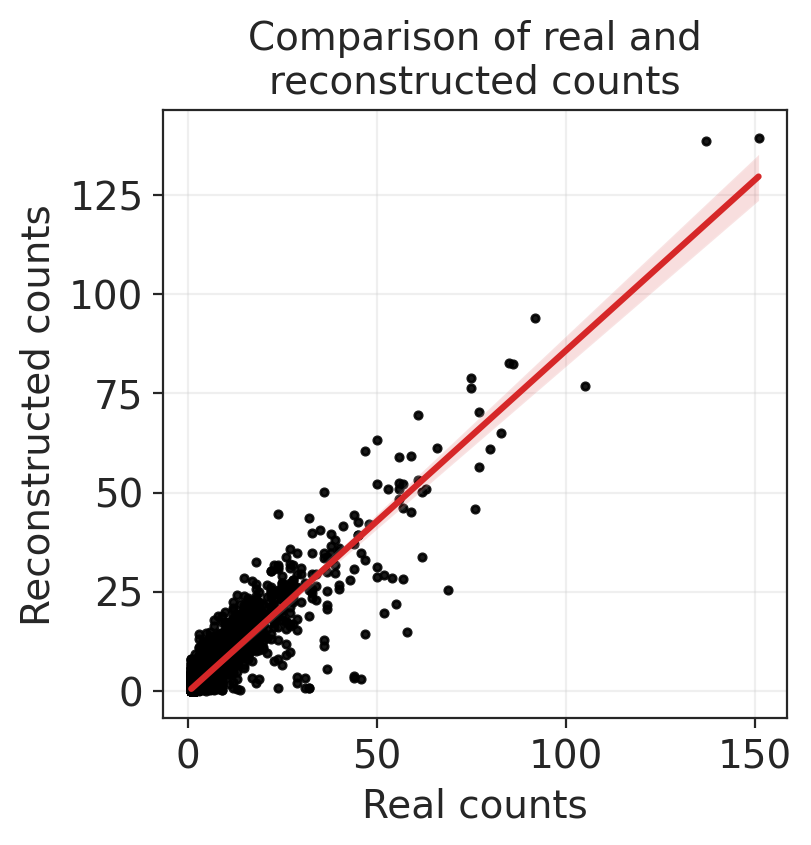

In [5]:
# Reconstructed counts will be in a dense format — be aware
# because reconstruction returns Poisson means

adata.layers["reconstructed"] = model.reconstruct_counts()

predicted_counts = adata.layers["reconstructed"][
    adata.X.nonzero()[0],
    adata.X.nonzero()[1]
]
real_counts = adata.X.data

subsample = np.random.choice(
    np.arange(len(predicted_counts)),
    size=10000,
    replace=False,
) # Subsampling fraction

fig, ax = plt.subplots(figsize=(4, 4))

sns.regplot(
    x=real_counts[subsample],
    y=predicted_counts[subsample],
    scatter_kws={
        "alpha": 0.9,
        "s": 7,
        "color": "black",
    },
    line_kws={
        "color": sns.color_palette()[3],
    }
)
ax.set_xlabel("Real counts")
ax.set_ylabel("Reconstructed counts")
ax.grid(alpha=0.3)
ax.set_title("Comparison of real and\nreconstructed counts")

We can check how good this correlation is:

In [6]:
from scipy.stats import pearsonr

r, p = pearsonr(real_counts[subsample], predicted_counts[subsample])
print(f"Correlation between real and reconstructed counts: {r:.3f}", end=" ")
print(f"(p-value = {p})")

Correlation between real and reconstructed counts: 0.929 (p-value = 0.0)


Let's check the convergence during the training process.

Text(0.5, 1.0, 'Training process')

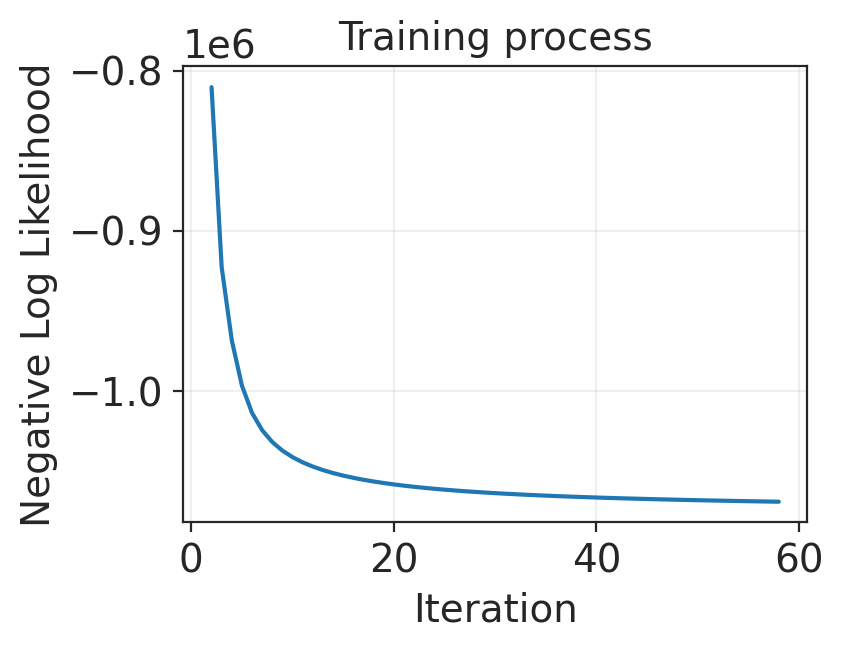

In [7]:
fig, ax = plt.subplots(figsize=(4, 3))

sns.lineplot(
    x=np.arange(len(model.loglik_history_))[2:],
    y=-np.array(model.loglik_history_[2:]),
    ax=ax,
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Negative Log Likelihood")
ax.grid(alpha=0.3)
ax.set_title("Training process")

Now we can plot first components.

<Axes: xlabel='X_glmpca4', ylabel='X_glmpca5'>

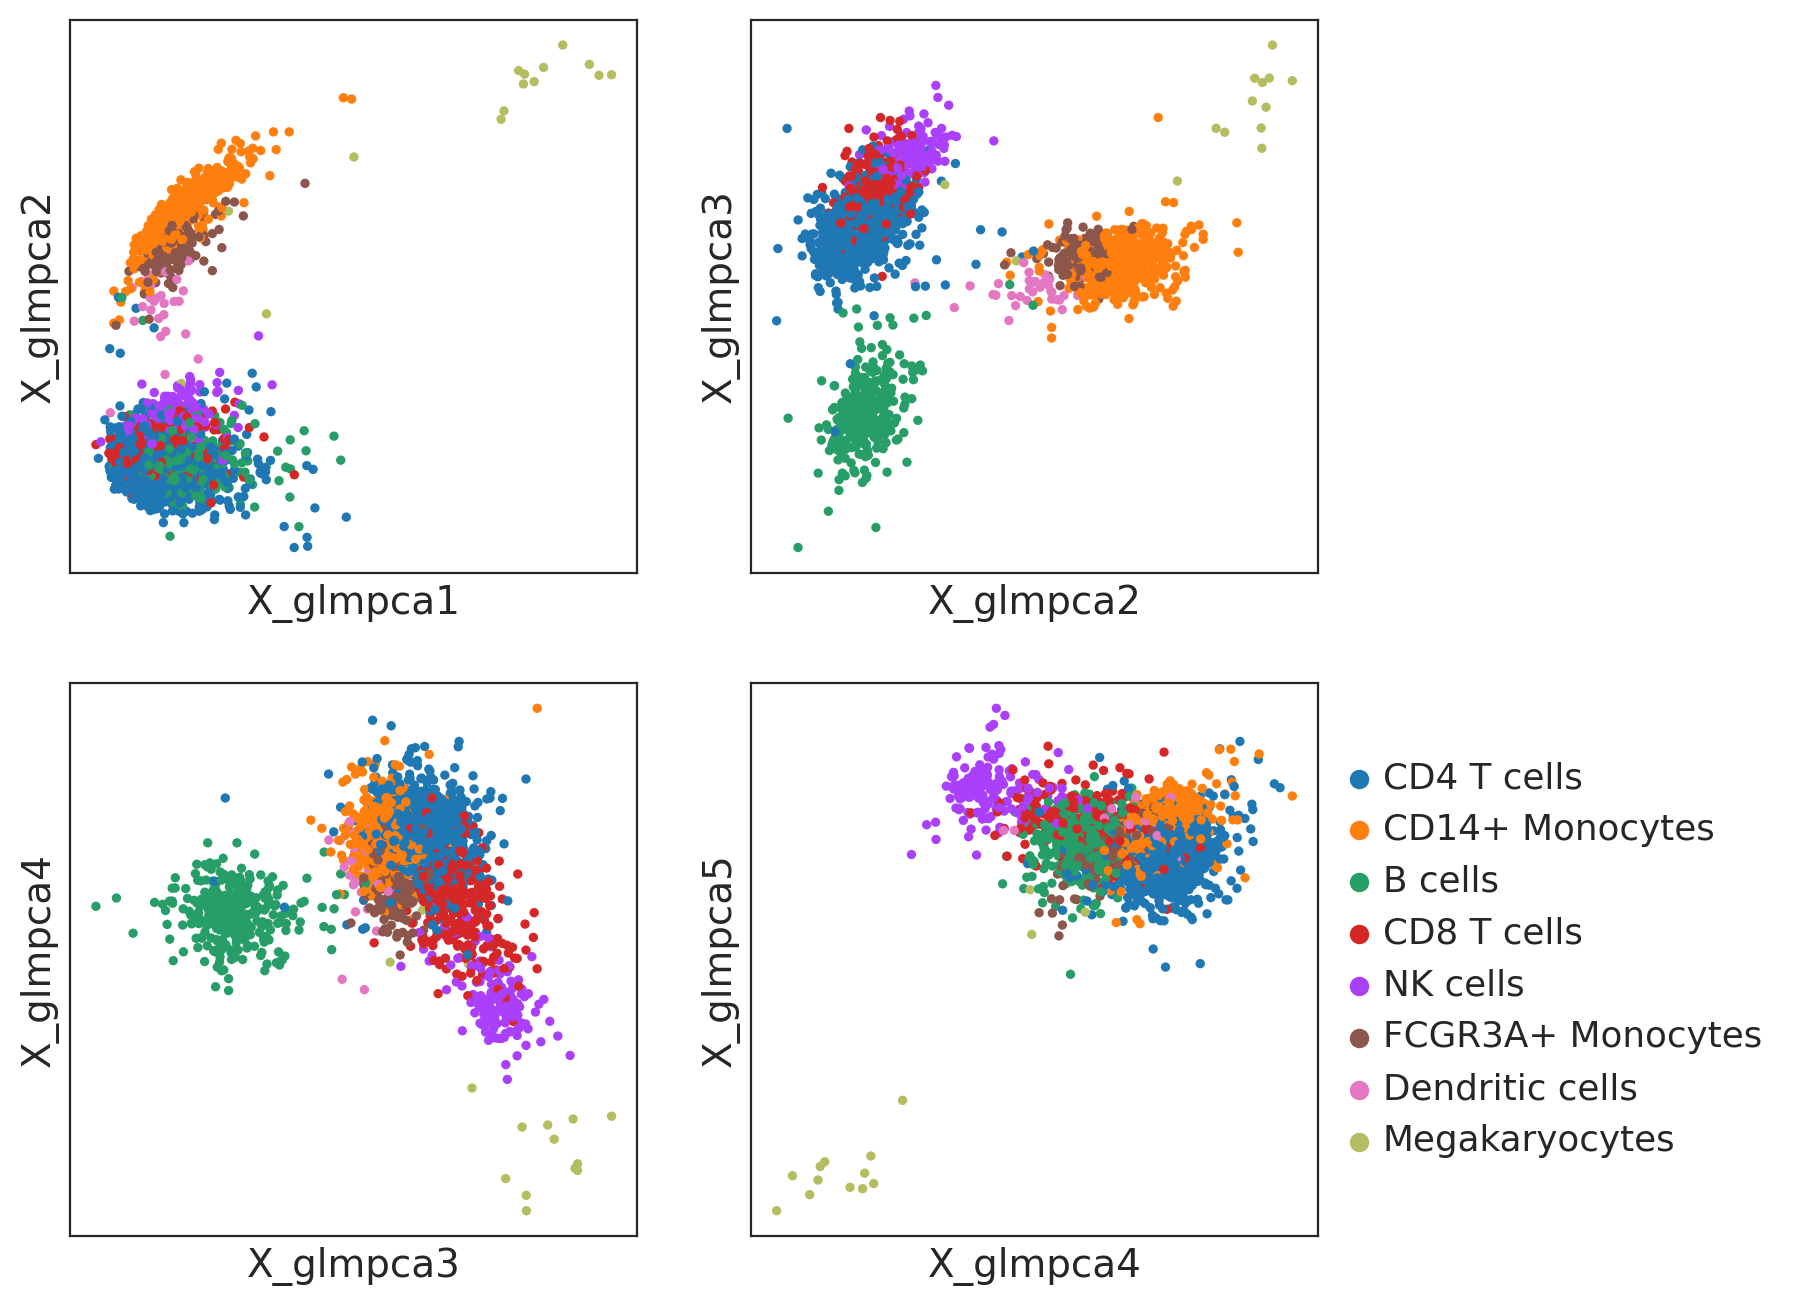

In [8]:
adata.obsm["X_glmpca"] = model.U

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8, 8), dpi=100)

sc.pl.embedding(adata, basis="X_glmpca", color="cell_type", legend_loc=None,
                components="1,2", title="", ax=axes[0, 0], show=False)
sc.pl.embedding(adata, basis="X_glmpca", color="cell_type", legend_loc=None,
                components="2,3", title="", ax=axes[0, 1], show=False)
sc.pl.embedding(adata, basis="X_glmpca", color="cell_type", legend_loc=None,
                components="3,4", title="", ax=axes[1, 0], show=False)
sc.pl.embedding(adata, basis="X_glmpca", color="cell_type",
                components="4,5", title="", ax=axes[1, 1], show=False)

And, after all, we can use this embedding to build a graph for visualization and clustering purposes.

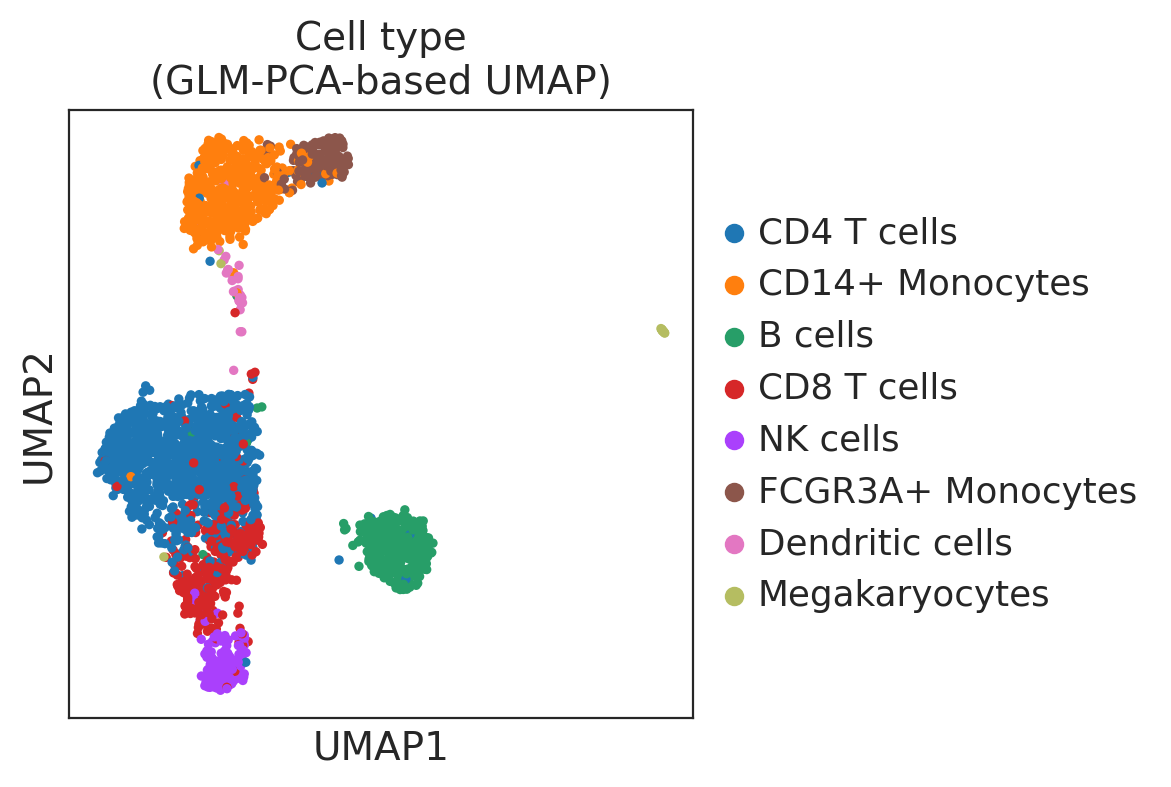

In [20]:
sc.pp.neighbors(adata, use_rep="X_glmpca")
sc.tl.umap(adata, min_dist=0.3)

sc.pl.umap(adata, color="cell_type", title="Cell type\n(GLM-PCA-based UMAP)")

Let's check how long does it take for the model to converge on CPU (let's assume that the convergence will be reached after 57 iterations and compute amount of time needed for only three iterations).

In [21]:
model = fastglmpca.poisson(adata.X, n_pcs=20, return_model=True, device="cpu",
                           max_iter=3)

GLM-PCA Iterations: 100%|██████████| 3/3 [01:45<00:00, 35.08s/it, delta=1.36e-01, loglik=917321.0000, lr=2.50e-01]
/usr/local/lib/python3.12/dist-packages/fastglmpca/utils.py:666: UserWarning: 
Maximum iterations (3) reached without convergence.
  warnings.warn(f"\nMaximum iterations ({self.max_iter}) reached without convergence.")


We see that each iteration takes approximately 35 seconds (on GPU it's approximately 0.87 seconds), so we have a significant improvement.